In [3]:
import numpy as np
import pandas as pd
from sklearn import model_selection, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from copy import copy 
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

#### Data Preprocessing

In [32]:
df = pd.read_csv("data/Cancer_data.csv")

# print(df.info())

missing_values = df.isna().sum()
# print(f"Missing values:\n{missing_values[missing_values > 0]}")  # Only prints columns with missing values

# Check number of benign results.
# print(np.sum(df["diagnosis"] == "B"))

# Transform feature from string to binary. Benign is now '0', and Malignant is '1'.
df["diagnosis"] = df["diagnosis"].map({"B": 0, "M": 1})

# print(df.iloc[0])

# Select target attribute
y = df["diagnosis"]

# Drop useless features
X = df.drop(["Unnamed: 32", "diagnosis", "id"], axis=1)
# print(df.columns)
X = np.array(X)
y = np.array(y)


scaler = StandardScaler()
X = scaler.fit_transform(X)

# Manual standardization
# mean = np.mean(X, axis=0)  # Compute mean for each feature
# std = np.std(X, axis=0)  # Compute standard deviation for each feature
# # Avoid division by zero
# std[std == 0] = 1  
# X = (X - mean) / std  # Standardization formula

# NOTE: Might be worth handling class imbalances somehow, currently it is 357(benign) to 212(malignant)
# NOTE: Consider other model performance measurements than simply missclassification rate, maybe specificity(FNR). Consider ROC/AUC
# NOTE: Show confusion matrix?
# NOTE: Include explainability of final model? Shapley value?
# NOTE: Show effect of model regularization on train and test error? Perhaps do this together with hyper parameter optimization?
# NOTE: Hyper parameter optimization. For log reg, regularization strength.


# pd.DataFrame(X).describe()



In [5]:
# pca_full = PCA().fit(X)
# plt.figure(figsize=(8, 5))
# plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.title('PCA - Explained Variance vs. Number of Components')
# plt.show()  

In [6]:
pca = PCA(n_components=0.95).fit(X)
X_pca = pca.transform(X)
# X_pca = pca.fit_transform(X)
comp = pca.components_
print(comp.shape)
print(X_pca.shape)
# print(X_pca.shape)

# Check how many components were selected
# print(f"Number of components selected: {X_pca.shape[1]}")

(10, 30)
(569, 10)


#### Building Base Models

In [7]:
class BaseLogisticRegression:
    def __init__(self, learning_rate=0.00001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations=num_iterations
        self.weights = None

    def sigmoid(self, x):
        return 1 / (1+np.exp(-x))
        # return np.where(x >= 0, 
        #             1 / (1 + np.exp(-x)), 
        #             np.exp(x) / (1 + np.exp(x)))

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        for i in range(self.num_iterations):
            p = self.sigmoid(X @ self.weights)
            lossGradient = X.T @ (y - p) / num_samples
            self.weights = self.weights + self.learning_rate * (lossGradient)
            
            # Print loss
            # if i % 100 == 0:  # Print every 100 iterations
            #     loss = -np.mean(y * np.log(p + 1e-15) + (1 - y) * np.log(1 - p + 1e-15))
            #     print(f"Iteration {i}: Loss = {loss:.4f}")

    def predict_proba(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        probs = self.sigmoid(X @ self.weights)
        return np.column_stack([1 - probs, probs])  # Convert to (n_samples, 2) format

    def predict(self, X, threshold=0.49864656):
        # X = np.hstack([np.ones([X.shape[0], 1]), X])
        probabilities = self.predict_proba(X)[:,1]

        # linear_combination = X @ self.weights
        # activated = self.sigmoid(linear_combination)
        # prediction = activated > threshold
        return probabilities > threshold
    
class BaseKNN:
    def __init__(self, X, y, K=5, distanceMeasure="Euclidean"):
        self.K = K
        self.X = X
        self.y = y
        self.distanceMeasure = distanceMeasure

    def fit(self, X, y):
        self.X = X
        self.y = y

    def getDistance(self, x1, x2):
        if self.distanceMeasure == "Euclidean":
            # distance = np.sqrt(np.sum((x1 - x2)**2))
            distance = np.linalg.norm(x1 - x2)
        return distance

    def get_K_NN(self, x):
        distances = np.array([self.getDistance(row, x) for row in self.X])
        K_neighbours_indices = np.argsort(distances)[:self.K]
        NN_classes = self.y[K_neighbours_indices]
        
        return NN_classes
    
    def predict(self, X):
        toPrint = [self.get_K_NN(x) for x in X]
        toPrint = np.array(toPrint)
        print(toPrint.shape)
        predictions = [stats.mode(self.get_K_NN(x), keepdims=False).mode for x in X]
        return np.array(predictions)
        # K_NN = self.get_K_NN(x)
        # # print(K_NN.shape)
        # return stats.mode(K_NN)

class BaseSoftKNN:
    def __init__(self, X, y, K=5, distanceMeasure="Euclidean"):
        self.K = K
        self.X = X
        self.y = y
        self.distanceMeasure = distanceMeasure

    def fit(self, X, y):
        self.X = X
        self.y = y

    def getDistance(self, x1, x2):
        if self.distanceMeasure == "Euclidean":
            # distance = np.sqrt(np.sum((x1 - x2)**2))
            distance = np.linalg.norm(x1 - x2)
        return distance

    def get_K_NN(self, x):
        distances = np.array([self.getDistance(row, x) for row in self.X])
        K_neighbours_indices = np.argsort(distances)[:self.K]
        NN_classes = self.y[K_neighbours_indices]
        
        return NN_classes
    
    def predict_proba(self, X):
        classes = [self.get_K_NN(x) for x in X]
        probas = np.sum(np.array(classes), axis=1) / self.K
        return np.column_stack([1 - probas, probas]) # Convert to (n_samples, 2) format
    
    def predict(self, X, threshold=0.5):
        probas = self.predict_proba(X)
        predictions = (probas > threshold).astype(int)
        # return predictions
        return predictions[:, 1]



#### Evaluating Models

In [8]:
def kfold_evaluation(K, model, X, y, threshold=0.49864656):
    CV = model_selection.KFold(n_splits=K, shuffle=True)

    all_y_true = []
    all_y_prob = []

    for train_index, test_index in CV.split(X):
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]
        
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        
        all_y_true.extend(y_test)
        all_y_prob.extend(y_prob)

    y_est_global = (np.array(all_y_prob) >= threshold).astype(int)
    cm = confusion_matrix(all_y_true, y_est_global, labels=[0, 1])

    fpr_roc, tpr_roc, thresholds = metrics.roc_curve(all_y_true, all_y_prob)
    auc = metrics.auc(fpr_roc, tpr_roc)

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

    precision = tp / (tp + fp)
    error = (fp + fn) / len(all_y_true)
    accuracy = 1 - error
    f1_score = (2 * tp) / (2 * tp + fp + fn)
    
    return accuracy, error, f1_score, auc, fpr, tpr, fnr, tnr, precision

def kfold_evaluation_outliers_removed(K, model, X, y, threshold=0.49864656):
    CV = model_selection.KFold(n_splits=K, shuffle=True)

    all_y_true = []
    all_y_prob = []

    for train_index, test_index in CV.split(X):
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]
        
        # mean = np.mean(X_train, axis=0)
        # std = np.std(X_train, axis=0)

        non_outliers = np.all(np.abs(X_train) < 5, axis=1)

        X_train_clean = X_train[non_outliers]
        y_train_clean = y_train[non_outliers]

        model.fit(X_train_clean, y_train_clean)

        y_prob = model.predict_proba(X_test)[:, 1]
        
        all_y_true.extend(y_test)
        all_y_prob.extend(y_prob)

    y_est_global = (np.array(all_y_prob) >= threshold).astype(int)
    cm = confusion_matrix(all_y_true, y_est_global, labels=[0, 1])

    fpr_roc, tpr_roc, thresholds = metrics.roc_curve(all_y_true, all_y_prob)
    auc = metrics.auc(fpr_roc, tpr_roc)

    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

        
    error = (fp + fn) / len(all_y_true)
    accuracy = 1 - error
    f1_score = (2 * tp) / (2 * tp + fp + fn)
    
    return accuracy, error, f1_score, auc, fpr, tpr, fnr, tnr

def kfold_accuracy(K, model, X, y, threshold=0.49864656):
    CV = model_selection.KFold(n_splits=K, shuffle=True)

    errors = np.zeros(K)
    i = 0
    for train_index, test_index in CV.split(X):
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        fold_error = np.sum(y_pred != y_test) / len(y_test)
        errors[i] = fold_error
        i += 1

        # y_prob = model.predict_proba(X_test)[:, 1]
        
    
    
    # y_est_global = (np.array(all_y_prob) >= threshold).astype(int)
    avg_error = np.mean(errors)
        
    # error = (fp + fn) / len(all_y_true)
    accuracy = 1 - avg_error
    
    return accuracy, avg_error

def get_kfold_roc(K, model, X, y):
    CV = model_selection.KFold(n_splits=K, shuffle=True)
    
    all_y_true = []
    all_y_prob = []

    for train_index, test_index in CV.split(X):
        X_train, y_train = X[train_index, :], y[train_index]
        X_test, y_test = X[test_index, :], y[test_index]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probability estimates

        all_y_true.extend(y_test)
        all_y_prob.extend(y_prob)

    # Compute overall ROC
    fpr, tpr, thresholds = metrics.roc_curve(all_y_true, all_y_prob)
    auc = metrics.auc(fpr, tpr)

    return fpr, tpr, auc, thresholds

def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random guess line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


### ROC Graph and AUC Analysis 

In [9]:
# K = X.shape[0]
K = 10
fpr, tpr, auc, thresholds = get_kfold_roc(K, LogisticRegression(), X, y)
# fpr2, tpr2, auc2, thresholds2 = get_kfold_roc(10, LogisticRegression(), X, y)

# plot_roc_curve(fpr, tpr, auc)

# for i in range(len(thresholds)):
#     print(f"Threshold: {thresholds[i]:.8f}, FPR: {fpr[i]:.8f}, TPR: {tpr[i]:.8f}")

In [ ]:
def evaluate_model(model, name, xTest, yTest):
    y_pred = model.predict(xTest)
    y_proba = model.predict_proba(xTest)[:, 1]
    print(f"\n{name} Evaluation:")
    print("Confusion Matrix:")
    print(confusion_matrix(yTest, y_pred))
    print("Classification Report:")
    print(classification_report(yTest, y_pred, digits=5))
    print("ROC AUC Score:", roc_auc_score(yTest, y_proba))
    RocCurveDisplay.from_estimator(model, xTest, yTest)
    plt.title(f"ROC Curve - {name}")
    plt.show()


def evaluateModelLOOCV(model, X, y):
    loo = LeaveOneOut()
    y_true = []
    y_pred = []
    y_proba = []

    for train_index, test_index in loo.split(X):
        xTrain, xTest = X[train_index], X[test_index]
        yTrain, yTest = y[train_index], y[test_index]

        model.fit(xTrain, yTrain)
        pred = model.predict(xTest)
        proba = model.predict_proba(xTest)[:, 1]

        y_true.append(yTest[0])
        y_pred.append(pred[0])
        y_proba.append(proba[0])

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    print("\nLogReg Evaluation with Leave-One-Out CV:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=5))
    print("ROC AUC Score:", roc_auc_score(y_true, y_proba))

    # Plot ROC Curve using actual predictions
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title("ROC Curve - LogReg (LOOCV)")
    plt.show()


### Logistic Regression


LogReg Evaluation with Leave-One-Out CV:
Confusion Matrix:
[[355   2]
 [  7 205]]
Classification Report:
              precision    recall  f1-score   support

           0    0.98066   0.99440   0.98748       357
           1    0.99034   0.96698   0.97852       212

    accuracy                        0.98418       569
   macro avg    0.98550   0.98069   0.98300       569
weighted avg    0.98427   0.98418   0.98414       569

ROC AUC Score: 0.9950848263833835


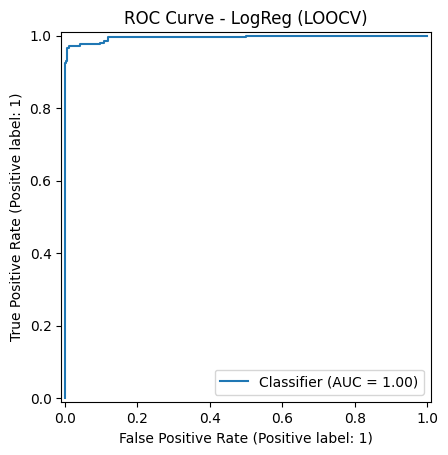

In [11]:
logReg = LogisticRegression(C=0.55, max_iter=1000)
evaluateModelLOOCV(logReg, X, y)

In [12]:
from sklearn.metrics import PrecisionRecallDisplay



# display = PrecisionRecallDisplay.from_estimator(
#     classifier, X_test, y_test, name="LinearSVC", plot_chance_level=True, despine=True
# )
# _ = display.ax_.set_title("2-class Precision-Recall curve")

#### KNN


LogReg Evaluation with Leave-One-Out CV:
Confusion Matrix:
[[354   3]
 [ 14 198]]
Classification Report:
              precision    recall  f1-score   support

           0    0.96196   0.99160   0.97655       357
           1    0.98507   0.93396   0.95884       212

    accuracy                        0.97012       569
   macro avg    0.97352   0.96278   0.96769       569
weighted avg    0.97057   0.97012   0.96995       569

ROC AUC Score: 0.9867541356165108


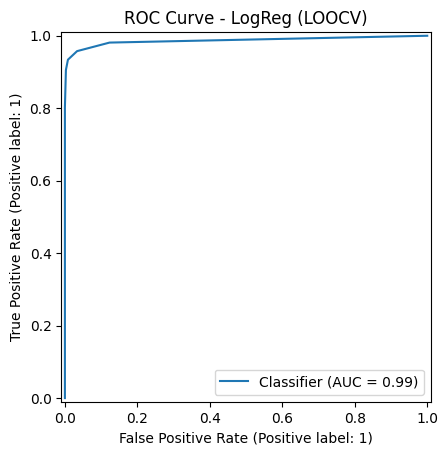

In [ ]:
# K = 10
# Compare base KNN to task KNN through K-fold cross validation
# base_accuracy, base_error, base_f1_score, base_auc, base_fpr, base_tpr, base_fnr, base_tnr, base_precision = kfold_evaluation(K, BaseSoftKNN(X, y, 5), X, y)
# nonbase_accuracy, nonbase_error, nonbase_f1_score, nonbase_auc, nonbase_fpr, nonbase_tpr, nonbase_fnr, nonbase_tnr, nonbase_precision = kfold_evaluation(K, KNeighborsClassifier(n_neighbors=5), X, y)

# print(f"Base model accuracy: {base_accuracy}\nBase model error: {base_error}\nBase f1 Score: {base_f1_score}\nBase model AUC: {base_auc}\nBase model fnr: {base_fnr}\nBase model fpr: {base_fpr}\n")
# print(f"Nonbase model accuracy: {nonbase_accuracy}\nNonbase model error: {nonbase_error}\nNonBase f1 Score: {nonbase_f1_score}\nNonBase model AUC: {nonbase_auc}\nNonBase model fnr: {nonbase_fnr}\nNonBase model fpr: {nonbase_fpr}\n")

baseKNN = BaseSoftKNN(X, y, 5)
evaluateModelLOOCV(baseKNN, X, y)
# KNN = KNeighborsClassifier(n_neighbors=5)
# evaluateModelLOOCV(KNN, X, y)

#### SVM


LogReg Evaluation with Leave-One-Out CV:
Confusion Matrix:
[[352   5]
 [  8 204]]
Classification Report:
              precision    recall  f1-score   support

           0    0.97778   0.98599   0.98187       357
           1    0.97608   0.96226   0.96912       212

    accuracy                        0.97715       569
   macro avg    0.97693   0.97413   0.97550       569
weighted avg    0.97714   0.97715   0.97712       569

ROC AUC Score: 0.9953094445325299


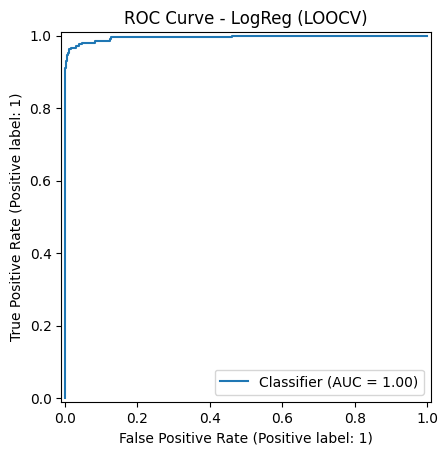

In [36]:
# K = X.shape[0]
# accuracy, error = kfold_accuracy(K, svm.SVC(kernel="rbf"), X, y)
# nonbase_accuracy, nonbase_error, nonbase_f1_score, nonbase_auc, nonbase_fpr, nonbase_tpr, nonbase_fnr, nonbase_tnr, nonbase_precision = kfold_evaluation(K, svm.SVC(kernel="linear", probability=True), X, y)
# model.fit(X,y)

# print(accuracy, error)
# print(f"Nonbase model accuracy: {nonbase_accuracy}\nNonbase model error: {nonbase_error}\nNonBase f1 Score: {nonbase_f1_score}\nNonBase model AUC: {nonbase_auc}\nNonBase model fnr: {nonbase_fnr}\nNonBase model fpr: {nonbase_fpr}\n")

model = svm.SVC(kernel="rbf", probability=True)
evaluateModelLOOCV(model, X, y)

In [ ]:
K = X.shape[0]
# K = 10
# model = BaggingClassifier(LogisticRegression(max_iter=1000))
# accuracy, error = kfold_accuracy(K, BaggingClassifier(LogisticRegression()), X, y)
# accuracy, error = kfold_accuracy(K, AdaBoostClassifier(LogisticRegression()), X, y)
accuracy, error, f1_score, auc, fpr, tpr, fnr, tnr = kfold_evaluation_outliers_removed(K, RandomForestClassifier(), X, y)
print(f"Model accuracy: {accuracy}\nModel error: {error}\nf1 Score: {f1_score}\nModel AUC: {auc}\nModel fnr: {fnr}\nModel fpr: {fpr}\n")

# print(accuracy, error)

Model accuracy: 0.9613356766256591
Model error: 0.03866432337434095
f1 Score: 0.9478672985781991
Model AUC: 0.9866087944611808
Model fnr: 0.05660377358490566
Model fpr: 0.028011204481792718



In [16]:
class simpleSVM:
    def __init__(self, kernel='linear', C=1.0, degree=3, gamma=None, learning_rate=0.01, n_iters=1000):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.alpha = None
        self.b = 0
        self.X_train = None
        self.y_train = None

    def kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return x1 @ x2
        elif self.kernel == 'poly':
            return ((x1 @ x2) + 1)**self.degree
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / x1.shape[0]   
            return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)
        else: 
            raise ValueError("Unknown kernel")


    def fit(self, X, y):
        self.X_train = copy(X)
        self.y_train = copy(y)
        n_samples, _ = X.shape
        self.alpha = np.zeros(n_samples)

        for _ in range(self.n_iters):
            for i in range(n_samples):
                gradient = 1 - y[i] * sum(self.alpha[j] * y[j] * self.kernel_function(X[i], X[j]) for j in range(n_samples))
                self.alpha[i] += self.learning_rate * gradient
                self.alpha[i] = min(max(self.alpha[i], 0), self.C)

        self.b = 1 / X.shape[0] * sum(y[i] - sum(
            self.alpha[j] * y[j] * self.kernel_function(X[j], X[i])
            for j in range(n_samples)) 
            for i in range(n_samples))
        
    def predict(self, X):
        predictions = np.sign([
            np.sum(
                self.alpha * self.y_train * [self.kernel_function(x_i, x) for x_i in self.X_train] + self.b for x in X
            )
        ])
        return predictions